   cluster   mse_mean    mse_std   r2_mean    r2_std  n_samples
0        0  93.416161   7.398669  0.290026  0.104504        292
1        1  98.982296   8.876440  0.282741  0.102904        316
2        2  78.572375  10.142476  0.382559  0.027521        255


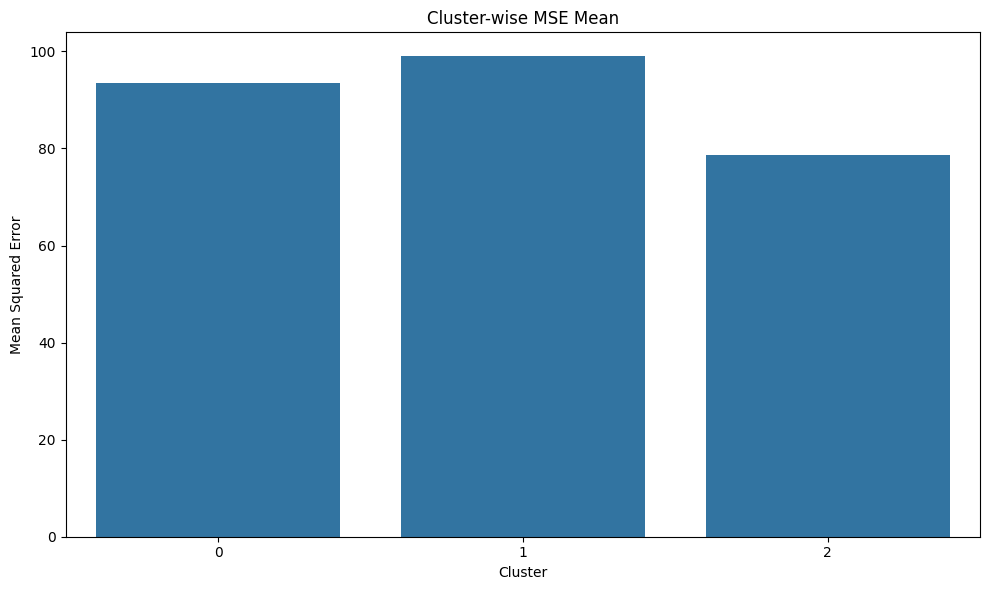

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

df.drop(columns=["date"], inplace=True)

#to lowercase
df['staff_experience'] = df['staff_experience'].astype(str).str.lower().str.strip()
df['waste_category'] = df['waste_category'].astype(str).str.lower().str.strip()

# 이상치 처리
mode_temp = df['temperature_C'][(df['temperature_C'] > 0) & (df['temperature_C'] < 36)].mode()[0]
df.loc[(df['temperature_C'] <= 0) | (df['temperature_C'] >= 36), 'temperature_C'] = mode_temp

df = df[df['meals_served'] < 500]

# 수치형 결측치 처리
df['temperature_C'] = df['temperature_C'].fillna(mode_temp)
df['past_waste_kg'] = df['past_waste_kg'].fillna(df['past_waste_kg'].mean())

# experience 결측치 처리
df['staff_experience'] = df['staff_experience'].replace(['nan', 'None', 'NaN'], np.nan)
def fill_staff_experience(row):
    if pd.isnull(row['staff_experience']):
        staff = row['kitchen_staff']
        waste = row['past_waste_kg']

        if staff < 12 and waste > 20:
            return 'beginner'
        elif staff > 17 and waste < 15:
            return 'expert'
        else:
            return 'intermediate'
    return row['staff_experience']

df['staff_experience'] = df.apply(fill_staff_experience, axis=1)

# experience 수동 인코딩
experience_order = {
    'beginner': 0,
    'intermediate': 1,
    'expert': 2
}
df['staff_experience'] = df['staff_experience'].map(experience_order)

# waste_category Label 인코딩
label_encoders = {}
categorical_cols = ["waste_category"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 요인 별 clustering
env_features = ['temperature_C', 'humidity_percent']
ops_features = ['meals_served', 'special_event', 'day_of_week']
human_features = ['kitchen_staff', 'staff_experience']

# 정규화

# 요인 내 정규화 및 요인 score 계산
def normalize_group(df, features):  
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(df[features])
    return pd.DataFrame(normed, columns=features).mean(axis=1)


df['env_score'] = normalize_group(df, env_features)
df['ops_score'] = normalize_group(df, ops_features)
df['human_score'] = normalize_group(df, human_features)

# 요인 score 정규화
score_df = df[['env_score', 'ops_score', 'human_score']]
score_scaler = MinMaxScaler()
df[['env_score_norm', 'ops_score_norm', 'human_score_norm']] = score_scaler.fit_transform(score_df)

df = df.dropna(subset=[
    'env_score', 'ops_score', 'human_score',
    'env_score_norm', 'ops_score_norm', 'human_score_norm',
    'food_waste_kg'
])
df = df.copy()


cluster_input = df[['env_score_norm', 'ops_score_norm', 'human_score_norm']]

# 클러스터링
cluster_input = df[['env_score_norm', 'ops_score_norm', 'human_score_norm']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[cluster_input.columns])

predictors = env_features + ops_features + human_features
scaler = StandardScaler()
df[predictors] = scaler.fit_transform(df[predictors])

# 클러스터별 회귀분석
target = 'food_waste_kg'
predictors = env_features + ops_features + human_features

cluster_mean = df.groupby('cluster')[['env_score_norm', 'ops_score_norm', 'human_score_norm']].mean()

# KFold 평가
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cluster_kfold_results = []
predictors = env_features + ops_features + human_features
target = 'food_waste_kg'

# KFold로 클러스터별 모델 평가
for cid in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cid]
    X = cluster_data[predictors].reset_index(drop=True)
    y = cluster_data[target].reset_index(drop=True)

    mse_list = []
    r2_list = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        mse_list.append(mean_squared_error(y_test, pred))
        r2_list.append(r2_score(y_test, pred))

    cluster_kfold_results.append({
        'cluster': cid,
        'mse_mean': np.mean(mse_list),
        'mse_std': np.std(mse_list),
        'r2_mean': np.mean(r2_list),
        'r2_std': np.std(r2_list),
        'n_samples': len(X)
    })

cluster_kfold_df = pd.DataFrame(cluster_kfold_results)

print(cluster_kfold_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='mse_mean', data=cluster_kfold_df, capsize=.1)
plt.title('Cluster-wise MSE Mean')
plt.xlabel('Cluster')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('cluster_mse_mean.png')